In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from dtw import dtw
from scipy.stats import poisson, norm
import time
import pickle

import light_curve as lc
import estimate_source_angles_detectors as esad

In [2]:
# open the neighbourhood GRB pickled file
with open('data/nbd_array', 'rb') as f:
    nbd = pickle.load(f)

Comparing the GRB's :

`(2, [6,17,23])`

2 = GRB141205018  ; this is the center 

6 = GRB150312403

17 = GRB170130697

23 = GRB220415645

In [3]:
# get the ra and dec values of grbs to compare
lcdf = pd.read_csv('data/gbmdatacleaned.csv', index_col=0) # light curve data frame

grb_index = nbd[1][1].copy()
grb_index.insert(0, nbd[1][0])
print(grb_index)

# ra-dec, name of selected grbs
ra = [] 
dec = [] 
grbnames = [] 
for i in grb_index:
    ra.append(lcdf.iloc[i].ra_val)
    dec.append(lcdf.iloc[i].dec_val)
    grbnames.append(lcdf.name.iloc[i])

grbnumbers = [x[3:] for x in grbnames] # GRB number

[2, 6, 17, 23]


In [4]:
grbt90 = [lc.get_t90(name) for name in grbnames]
grbbinsize = [lc.binsize(t90) for t90 in grbt90]

In [5]:
# find the name of the brightest NaI detector

detectors = [] # brightest detector name
for i in range(len(grb_index)):
    # try suffix _v01 or _v00
    try:
        b = esad.angle_to_grb(ra[i],
                          dec[i],
                          '/Users/dimrisudhanshu/Downloads/current/glg_trigdat_all_bn' + grbnumbers[i] + '_v01.fit')
    except:
        b = esad.angle_to_grb(ra[i],
                          dec[i],
                          '/Users/dimrisudhanshu/Downloads/current/glg_trigdat_all_bn' + grbnumbers[i] + '_v00.fit')
    detectors.append(b[0])

detectors

['n8', 'n3', 'n3', 'n2']

In [6]:
# open the fits file corresponding to the brightest NaI detectors
fitfile1 = fits.open('/Users/dimrisudhanshu/Downloads/current/glg_tte_' + detectors[0] + '_bn' + grbnumbers[0] + '_v00.fit')
fitfile2 = fits.open('/Users/dimrisudhanshu/Downloads/current/glg_tte_' + detectors[1] + '_bn' + grbnumbers[1] + '_v01.fit')
fitfile3 = fits.open('/Users/dimrisudhanshu/Downloads/current/glg_tte_' + detectors[2] + '_bn' + grbnumbers[2] + '_v00.fit')
fitfile4 = fits.open('/Users/dimrisudhanshu/Downloads/current/glg_tte_' + detectors[3] + '_bn' + grbnumbers[3] + '_v00.fit')

fitfiles = [fitfile1, fitfile2, fitfile3, fitfile4]

DTW : 0.0
DTW : 211693.0
DTW : 2762.0
DTW : 1169.0


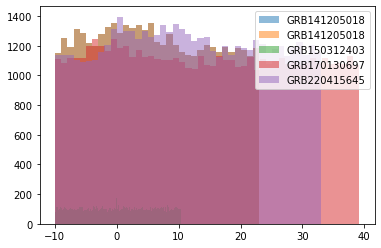

In [7]:
referenceLC = lc.getLightCurve(fitfile1) # reference fit file
ref_name = fitfile1[0].header['OBJECT'] # GRB name of reference
distance_list = [] # for DTW distances
for fitfile in fitfiles:
    targetLC = lc.getLightCurve(fitfile) # target fit file
    tar_name = fitfile[0].header['OBJECT'] # GRB name of target
    d = lc.getDTW(referenceLC, targetLC, ref_name, tar_name) # get DTW distance
    distance_list.append(d)
    print(f'DTW : {d}')

In [8]:
def simulate(fitfile, num, size = 0):
    '''
    function to simulate light curves with poisson distribution
    fitfile = GRB to simulate
    size = binsize of GRB
    num = number of simulated curves
    '''
    reference = lc.getLightCurve(fitfile, size)
    simcurves = [] # for simulated curves
    for i in range(num):
        curve = []
        for n in reference:
            curve.append(poisson.rvs(mu = n, size = 1)[0])
        simcurves.append(curve)
    
    return simcurves

Total time = 6.280372142791748


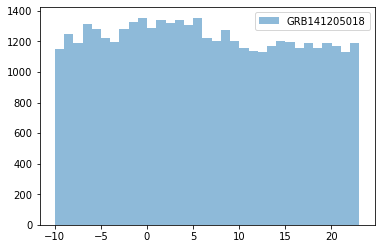

In [9]:
start_time = time.time()

simulated_curves = simulate(fitfile1, 100)
dtw_list = []
for curve in simulated_curves:
    d = lc.getDTW(referenceLC, curve, '', '')
    dtw_list.append(d)
    
end_time = time.time()

print(f'Total time = {end_time - start_time}')

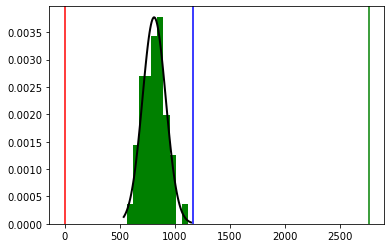

In [10]:
# mean and standard deviation of simulated dtw distance
mu, std = norm.fit(dtw_list)

# plot hist + normal distribution
plt.hist(dtw_list, density=True, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# dtw distance of target curves
plt.axvline(distance_list[0], color='r')
plt.axvline(distance_list[2], color='g')
plt.axvline(distance_list[3], color='b')

# number of stdev away from mean
stddev = []
for d in distance_list:
    stddev.append((abs(mu - d))/std)

In [11]:
datadf = pd.DataFrame({'Index':grb_index, 'Name':grbnames, 'Number':grbnumbers,
                       'Brightest Detector':detectors, 'ra': ra, 'dec':dec,
                       't90':grbt90, 'Binsize':grbbinsize, 'Distance':distance_list,
                       'Sigma':stddev})

In [12]:
datadf.head()

,Index,Name,Number,Brightest Detector,ra,dec,t90,Binsize,Distance,Sigma
0,2,GRB141205018,141205018,n8,294.61,-87.58,13.056,1.0,0.0,7.689685
1,6,GRB150312403,150312403,n3,285.49,-86.00,0.320,0.1,211693.0,1994.810618
2,17,GRB170130697,170130697,n3,296.39,-80.45,29.184,1.0,2762.0,18.437328
3,23,GRB220415645,220415645,n2,298.38,-79.82,23.040,1.0,1169.0,3.368417


Doubts : 
---
1. Reference light curve has 7 sigma difference with itself
2. Is position of T90 correct in the plot?

In [13]:
import light_curve as lc

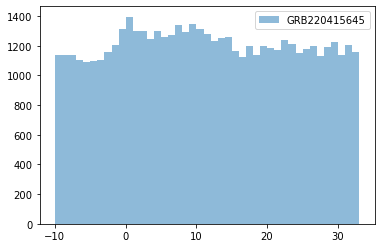

In [18]:
# DTW distance plot
tarLC = lc.getLightCurve(fitfile4)
tar_name = datadf.Name.iloc[3]

13.056 23.04


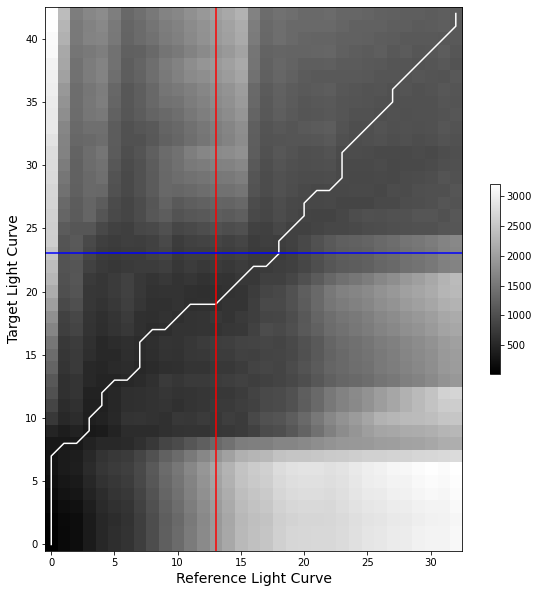

1169.0

In [19]:
lc.getDTW(referenceLC, tarLC, ref_name, tar_name, True)